# 14. Image classification by machine learning: Optical text recognition

There are different types of machine learning. In some cases, like in the pixel classification task, the algorithm does the classification on its own by trying to optimize groups according to a given rule (unsupervised). In other cases one has to feed the algorithm with a set of annotated examples to train it (supervised). Here we are going to train an ML algorithm to recognize digits. Therefore the first things that we need is a good set of annotated examples. Luckily, since this is a "popular" problem, one can find such datasets on-line. In general, this is not the case, and one has to manually create such a dataset. Then one can either decide on a set of features that the algorithm has to use for learning or let the algorithm define those itself. Here we look at the first case, and we will look at the second one in the following chapters.

Note that this notebooks does not present a complete OCR solution. The goal is rather to show the underlying principles of machine learning methods used for OCR.

In [22]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage
import skimage.feature
import course_functions
datapath = course_functions.define_data_path()

## 14.1 Exploring the dataset

We found a good dataset [here](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/) and downloaded it. Let's first have a look at it.

In [3]:
data_path = '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/'

We have a folder with 62 sub-folders corresponding to digits and lower and upper-case characters:

In [4]:
samples = np.sort(glob.glob(data_path+'*'))
print(samples)

['/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample001'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample002'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample003'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample004'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample005'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample006'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample007'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample008'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample009'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample010'
 '/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/English_print/Fnt/Sample011'
 '/Users/gw18g940/Desktop/Test_data/ImagePr

Let's check the contents by plotting the first 5 images of a folder:

In [13]:
files = glob.glob(samples[7]+'/*.png')


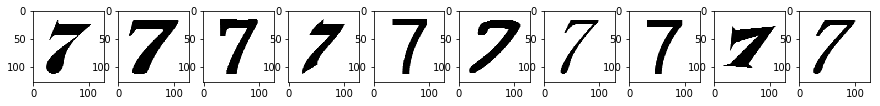

In [19]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(1,10,i+1)
    image = skimage.io.imread(files[i])
    plt.imshow(image, cmap = 'gray')
plt.show()

So we have samples of each character written with different fonts and types (italic, bold).

## 14.2 Classifying digits

We are first going to try to classify digits. Our goal is to be able to pass an image of the type shown above to our ML algorithm so that the latter can say what digit is present in that image.

First, we have to decide what information the algorithm should use to make that decision. The simplest thing to do is to just say that each pixel is a "feature", and thus to use a flattened version of each image as feature space.

So that the process is a bit faster we are going to rescale all the images to 32x32 pixels so that we have $32^2$ features.

### 14.2.1 Loading and scaling images

For each digit, we load 50 images by randomly selecting them. We rescale them and reshape them in a single comprehension list. Let's see what happens for one digit:

In [29]:
data = [np.reshape(skimage.transform.rescale(skimage.io.imread(files[x]),1/4),32**2) 
        for x in np.random.choice(np.arange(len(files)),10,replace=False)]

In [34]:
data[0].shape

(1024,)

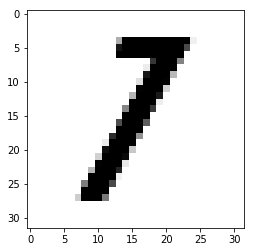

In [30]:
plt.imshow(np.reshape(data[2],(32,32)),cmap = 'gray')
plt.show()

Now let's do this for all digits and aggregate all these data into ```all_data```:

In [142]:
num_samples = 500

all_data = []
for ind, s in enumerate(samples[0:10]):
    files = glob.glob(s+'/*.png')
    
    data = np.array([np.reshape(skimage.transform.rescale(skimage.io.imread(files[x]),1/4),32**2) 
        for x in np.random.choice(np.arange(len(files)),num_samples,replace=False)])
    
    all_data.append(data)


/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Now we concatenate all these data into one single matrix:

In [143]:
data = np.concatenate(all_data,axis = 0)

In [144]:
data.shape

(5000, 1024)

### 14.2.2 Creating categories

We have 50 examples for 10 digits and each example has 1024 features. We also need to create an array that contains the information "what digit is present at each row of the ```data``` array. We have 500 times a list of each digit:

In [145]:
cats = [str(i) for i in range(len(all_data))]
category = np.concatenate([[cats[i] for j in range(num_samples)] for i in range(len(cats))])

In [146]:
category

array(['0', '0', '0', ..., '9', '9', '9'], dtype='<U1')

### 14.2.3 Running the ML algorithm

Now we are ready to use our dataset of features and our corresponding list of categories to train a classifier. We are going to use here a Random Forest classifier implement in scikit-learn:

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

First we have to split the dataset into a training and a testing dataset. It is very important to test the classifier on data that have not been seen previously by it!

In [148]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data, category, random_state=0)

Now we can do the actual learning:

In [149]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Finally we can verify the predictions on the test dataset. The predict function returns a list of the category to which each testing sample has been assigned.

In [150]:
ypred = model.predict(Xtest)

In [151]:
ypred

array(['0', '7', '9', ..., '0', '6', '4'], dtype='<U1')

We can look at a few examples:

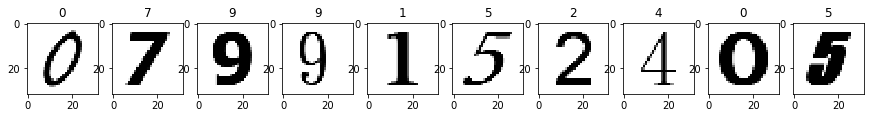

In [152]:
fig, ax = plt.subplots(1, 10, figsize = (15,10))
for x in range(10):
    ax[x].imshow(np.reshape(Xtest[x],(32,32)),cmap='gray')
    ax[x].set_title(ypred[x])
plt.show()

In order to get a more comprehensive view, we can look at some statistics:

In [153]:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       118
           1       0.96      0.94      0.95       128
           2       0.98      0.97      0.98       122
           3       0.94      0.98      0.96       113
           4       0.98      0.99      0.99       113
           5       0.96      0.96      0.96       139
           6       0.97      0.93      0.95       119
           7       1.00      0.98      0.99       132
           8       0.94      0.98      0.96       134
           9       0.97      0.97      0.97       132

   micro avg       0.97      0.97      0.97      1250
   macro avg       0.97      0.97      0.97      1250
weighted avg       0.97      0.97      0.97      1250



We see that our very simple features, basically the pixel positions, and 50 examples per class are sufficient to reach a very good result.

## 14.3 Using the classifier on "real" data

Let's try to segment a real-life case: an image of a digital screen:

In [154]:
jpg = skimage.io.imread('/Users/gw18g940/Desktop/Test_data/ImageProcessingCourse/digit.jpg')

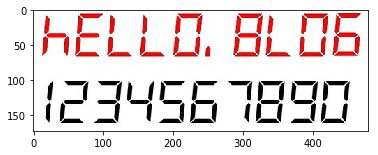

In [155]:
plt.imshow(jpg, cmap = 'gray')
plt.show()

### 14.3.1 Pre-processing

We trained our classifier on black and white pictures, so let's first convert the image and create a black and white version using a thresholder:

In [156]:
jpg = skimage.color.rgb2gray(jpg)
th = skimage.filters.threshold_li(jpg)
jpg_th = jpg<th

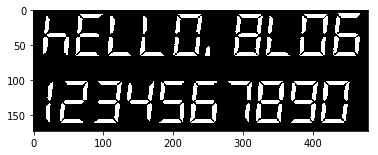

In [157]:
plt.imshow(jpg_th, cmap = 'gray')
plt.show()

### 14.3.2 Identifying numbers

First we need to identify each single number present here in the second row. If we project the image along the horizontal direction, we clearly see an "empty" region. By detecting where the steps are, we can isolate the two lines of text:

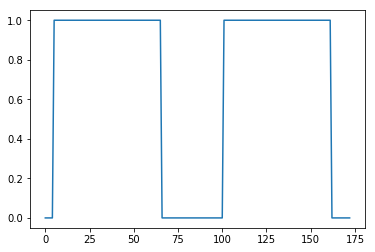

In [158]:
plt.plot(np.max(jpg_th,axis = 1))
plt.show()

In [159]:
#create projection
proj = np.max(jpg_th,axis = 1)
#select "positive" regions and find their indices
regions = proj > 0.5
text_indices = np.arange(jpg.shape[0])[regions]
#find the steps and split the indices into two groups
splits = np.split(text_indices,np.where(np.diff(np.arange(jpg.shape[0])[regions])>1)[0]+1)

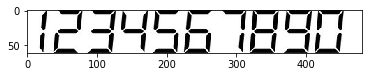

In [160]:
plt.imshow(jpg[splits[1],:],cmap = 'gray')
plt.show()

To separate each digit we proceed in the same way by projecting along the vertical dimensions:

In [161]:
#select line to process
line_ind = 1
proj2 = np.min(jpg[splits[line_ind],:],axis = 0)
regions = proj2 < 0.5
text_indices = np.arange(jpg.shape[1])[regions]
splits2 = np.split(text_indices,np.where(np.diff(np.arange(jpg.shape[1])[regions])>1)[0]+1)

```splits2``` contains all column indices for each digit:

In [162]:
characters = [jpg_th[splits[line_ind],x[0]:x[-1]] for x in splits2]

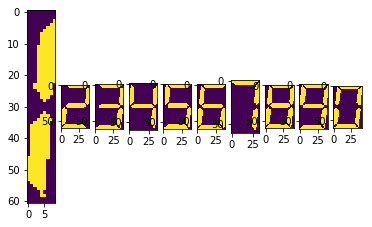

In [163]:
for ind, x in enumerate(characters):
    plt.subplot(1,10, ind+1)
    plt.imshow(x)
plt.show()

### 14.3.3 Rescaling

Since we rely on pixels positions as features, we have to make sure that the images we are passing to the classifier are similar to those used for training. Those had on average a height of 24 pixels. So let's rescale:

In [165]:
im_re = skimage.transform.rescale(characters[2],1/(characters[2].shape[0]/24), preserve_range=True, order = 0)

/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Additionally, the images are square and have 32 pixels. So let's pad our images. We do that by filling an empty image with our image at the middle. We also have to make sure that the intensity scale is correct:

In [166]:
empty = np.zeros((32,32))
empty[int((32-im_re.shape[0])/2):int((32-im_re.shape[0])/2)+im_re.shape[0],
     int((32-im_re.shape[1])/2):int((32-im_re.shape[1])/2)+im_re.shape[1]] = im_re
empty = empty<0.5

to_pass = (255*empty).astype(np.uint8)

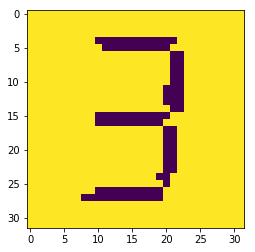

In [167]:
plt.imshow(empty)
plt.show()

Finally we can pass this to the classifier:

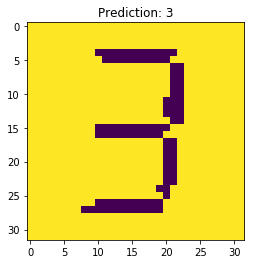

In [168]:
ypred = model.predict(np.reshape(to_pass,32**2)[np.newaxis,:])
fig,ax = plt.subplots()
plt.imshow(to_pass)
ax.set_title('Prediction: '+ ypred[0])
plt.show()

Let's do the same exercise for all digits:

/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/gw18g940/miniconda3/envs/pyimageprocessing/lib/py

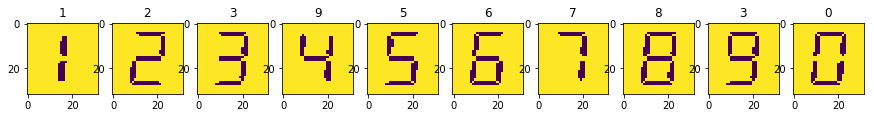

In [169]:
fig, ax = plt.subplots(1, 10, figsize = (15,10))
for x in range(10):
    final_size = 32
    
    im_re = skimage.transform.rescale(characters[x],1/(characters[x].shape[0]/24),preserve_range=True, order = 0)
    empty = np.zeros((32,32))
    empty[int((32-im_re.shape[0])/2):int((32-im_re.shape[0])/2)+im_re.shape[0],
         int((32-im_re.shape[1])/2):int((32-im_re.shape[1])/2)+im_re.shape[1]] = im_re
    to_pass = empty<0.5

    to_pass = (255*to_pass).astype(np.uint8)
    ypred = model.predict(np.reshape(to_pass,32**2)[np.newaxis,:])
    ax[x].imshow(to_pass)
    ax[x].set_title(ypred[0])
plt.show()

## 14.4 With all characters

In [172]:
category.shape

(6200,)

In [173]:
data.shape

(6200, 1024)

In [ ]:
num_samples = 100

all_data = []
for ind, s in enumerate(samples[0:62]):
    files = glob.glob(s+'/*.png')
    
    data = np.array([np.reshape(skimage.transform.rescale(skimage.io.imread(files[x]),1/4),32**2) 
        for x in np.random.choice(np.arange(len(files)),num_samples,replace=False)])
    
    all_data.append(data)
data = np.concatenate(all_data,axis = 0)

chars = 'abcdefghijklmnopqrstuvwxyz'
cats = [str(i) for i in range(10)]+[i for i in chars.upper()]+[i for i in chars]
category = np.concatenate([[cats[i] for j in range(num_samples)] for i in range(len(cats))])

Xtrain, Xtest, ytrain, ytest = train_test_split(data, category, random_state=0)

model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)

In [174]:
ypred = model.predict(Xtest)
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        31
           1       0.92      0.77      0.84        30
           2       0.88      0.95      0.91        22
           3       0.95      0.78      0.86        27
           4       0.84      0.72      0.78        29
           5       0.74      0.88      0.81        26
           6       0.85      0.77      0.81        22
           7       0.93      0.88      0.90        16
           8       0.82      0.93      0.87        29
           9       0.71      0.88      0.79        17
           A       0.91      0.83      0.87        24
           B       0.78      0.60      0.68        30
           C       0.48      0.62      0.54        16
           D       0.71      1.00      0.83        20
           E       0.81      0.85      0.83        20
           F       0.97      0.88      0.92        34
           G       0.80      0.94      0.86        17
           H       0.92    

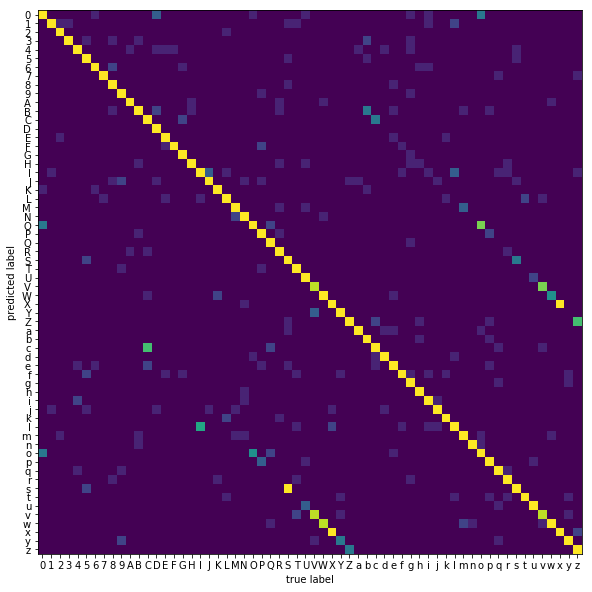

In [175]:
mat = confusion_matrix(ytest, ypred)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mat.T,vmin = 0,vmax = 10)#, square=True, annot=True, fmt='d', cbar=False)
plt.xticks(ticks=np.arange(62),labels=cats)
plt.yticks(ticks=np.arange(62),labels=cats)
plt.xlabel('true label')
plt.ylabel('predicted label');